In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.initializers import GlorotUniform
from sklearn.utils import class_weight
from IPython.display import clear_output
import os
import random
from itertools import product

# Ensure determinism
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)     # Python hashing
    os.environ['TF_DETERMINISTIC_OPS'] = '1'     # TensorFlow ops deterministic
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'   # CuDNN reproducibility (LSTM, CNN)
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
initial = pd.read_csv('data.csv')
print(initial.shape)
initial.head()

(78682, 21)


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [3]:
def encode_initial():
    # Encode status_label with 1 for failed and 0 for alive
    initial['status_label'] = initial['status_label'].map({'failed': 1, 'alive': 0})
    # Encode company_name with leading zeros
    initial['company_name'] = initial['company_name'].apply(lambda x: 'C_' + x.split('_')[1].zfill(4))
    # Encode years to counters
    initial['year'] = (
        initial.groupby('company_name')['year']
        .transform(lambda x: pd.Series(pd.factorize(x.sort_values())[0] + 1, index=x.sort_values().index).reindex(x.index))
    )

encode_initial()
initial.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_0001,0,1,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_0001,0,2,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_0001,0,3,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_0001,0,4,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_0001,0,5,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [4]:
# Building Sub-Dataframes
def builds_dfs(df):
    df = df.sort_values(by=['company_name', 'year']).reset_index(drop=True)
    features_initial = [f'X{i}' for i in range(1, 19)]
    eps = 1e-6 

    lag1_cols = {}
    for feat in features_initial:
        lag_feat = f'{feat}_lag1'
        lag_series = df.groupby('company_name')[feat].shift(1)
        lag_series = lag_series.where(~((lag_series.isna()) | (lag_series == 0)), df[feat])
        lag1_cols[lag_feat] = lag_series
    lag1_df = pd.DataFrame(lag1_cols)

    lag2_cols = {}
    for feat in features_initial:
        lag_feat = f'{feat}_lag2'
        lag_series = df.groupby('company_name')[feat].shift(2)
        lag_series = lag_series.where(~((lag_series.isna()) | (lag_series == 0)), df[feat])
        lag2_cols[lag_feat] = lag_series
    lag2_df = pd.DataFrame(lag2_cols)

    lag3_cols = {}
    for feat in features_initial:
        lag_feat = f'{feat}_lag3'
        lag_series = df.groupby('company_name')[feat].shift(3)
        lag_series = lag_series.where(~((lag_series.isna()) | (lag_series == 0)), df[feat])
        lag3_cols[lag_feat] = lag_series
    lag3_df = pd.DataFrame(lag3_cols)
    df = pd.concat([df, lag3_df], axis=1)

    sum3_cols = {}
    for feat in features_initial:
        sum_feat = f'{feat}_sum3'
        sum_series = df.groupby('company_name')[feat].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True)
        sum3_cols[sum_feat] = sum_series
    sum3_df = pd.DataFrame(sum3_cols)
    df = pd.concat([df, sum3_df], axis=1)

    avg3_cols = {}
    for feat in features_initial:
        avg_feat = f'{feat}_avg3'
        avg_series = df.groupby('company_name')[feat].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
        avg3_cols[avg_feat] = avg_series
    avg3_df = pd.DataFrame(avg3_cols)

    flags_cols = {}
    flags_cols['NWC'] = (df['X14'] > df['X1']).astype(int)
    flags_cols['NI_lag1'] = df.groupby('company_name')['X6'].shift(1).fillna(df['X6'])
    flags_cols['NI_lag2'] = df.groupby('company_name')['X6'].shift(2).fillna(df['X6'])
    flags_cols['ILTWO'] = ((flags_cols['NI_lag1'] < 0) | (flags_cols['NI_lag2'] < 0)).astype(int)
    flags_cols['NSL1'] = df.groupby('company_name')['X9'].shift(1).fillna(df['X9'])
    flags_cols['DNS'] = (df['X9'] < flags_cols['NSL1']).astype(int)
    flags_cols['CFN'] = (df['X4'] < 0).astype(int)
    flags_df = pd.DataFrame(flags_cols)

    ratios_cols = {}
    ratios_cols['CUR_R'] = df['X1'] / (df['X14'] + eps)
    ratios_cols['QUI_R'] = (df['X1'] - df['X2']) / (df['X14'] + eps)
    ratios_cols['CAS_R'] = df['X3'] / (df['X14'] + eps)
    ratios_cols['DEEQ'] = df['X16'] / (df['X7'] + eps)
    ratios_cols['LEV_R'] = df['X10'] / (df['X7'] + eps)
    ratios_cols['INTC'] = df['X12'] / (df['X5'] + eps)
    ratios_cols['ROA'] = df['X6'] / (df['X10'] + eps)
    ratios_cols['ROE'] = df['X6'] / (df['X7'] + eps)
    ratios_cols['GPM'] = (df['X9'] - df['X11']) / (df['X9'] + eps)
    ratios_cols['OPM'] = df['X4'] / (df['X9'] + eps)
    ratios_cols['NPM'] = df['X6'] / (df['X9'] + eps)
    ratios_cols['AST'] = df['X9'] / (df['X10'] + eps)
    ratios_cols['INVT'] = df['X11'] / (df['X2'] + eps)
    ratios_cols['MABO'] = df['X8'] / (df['X18'] + eps)
    ratios_cols['DIVP'] = df['X13'] / (df['X6'] + eps)
    ratios_df = pd.DataFrame(ratios_cols)
    
    ocomp_cols = {}
    ocomp_cols['TLTA'] = df['X17'] / (df['X10'] + eps)
    ocomp_cols['log_TLTA'] = np.log(ocomp_cols['TLTA'] + eps)
    ocomp_cols['WCTA'] = (df['X1'] - df['X14']) / (df['X10'] + eps)
    ocomp_cols['CLCA'] = df['X14'] / (df['X1'] + eps)
    ocomp_cols['OENEG'] = (df['X17'] > df['X10']).astype(int)
    ocomp_cols['NITA'] = df['X6'] / (df['X10'] + eps)
    ocomp_cols['FUTL'] = (df['X6'] + df['X3']) / (df['X17'] + eps)
    ocomp_cols['NITA_lag1'] = ocomp_cols['NITA'].groupby(df['company_name']).shift(1).fillna(ocomp_cols['NITA'])
    ocomp_cols['NITA_lag2'] = ocomp_cols['NITA'].groupby(df['company_name']).shift(2).fillna(ocomp_cols['NITA'])
    ocomp_cols['INTWO'] = ((ocomp_cols['NITA_lag1'] < 0) & (ocomp_cols['NITA_lag2'] < 0)).astype(int)
    ocomp_cols['NITA_diff'] = ocomp_cols['NITA'] - ocomp_cols['NITA_lag1']
    ocomp_cols['CHIN'] = ocomp_cols['NITA_diff'] / (ocomp_cols['NITA'].abs() + ocomp_cols['NITA_lag1'].abs() + eps)
    ocomp_cols['ohlson_o_score'] = (
            -1.32 
            - 0.407 * ocomp_cols['log_TLTA'] 
            + 6.03 * ocomp_cols['WCTA'] 
            - 1.43 * ocomp_cols['CLCA'] 
            + 0.0757 * ocomp_cols['OENEG'] 
            - 2.37 * ocomp_cols['NITA'] 
            - 1.83 * ocomp_cols['FUTL'] 
            + 0.285 * ocomp_cols['INTWO'] 
            - 0.521 * ocomp_cols['CHIN']
        )

    ocomp_df = pd.DataFrame(ocomp_cols)

    zcomp_cols = {}
    zcomp_cols['WC_TA'] = (df['X1'] - df['X14']) / (df['X10'] + eps)
    zcomp_cols['RE_TA'] = df['X15'] / (df['X10'] + eps)
    zcomp_cols['EBIT_TA'] = df['X12'] / (df['X10'] + eps)
    zcomp_cols['MVE_TL'] = df['X8'] / (df['X17'] + eps)
    zcomp_cols['S_TA'] = df['X9'] / (df['X10'] + eps)
    zcomp_cols['altman_z_score'] = (
            1.2 * zcomp_cols['WC_TA'] +
            1.4 * zcomp_cols['RE_TA'] +
            3.3 * zcomp_cols['EBIT_TA'] +
            0.6 * zcomp_cols['MVE_TL'] +
            1.0 * zcomp_cols['S_TA']
        )

    zcomp_df = pd.DataFrame(zcomp_cols)

    return [df, lag1_df, lag2_df, lag3_df, sum3_df, avg3_df, flags_df, ratios_df, ocomp_df, zcomp_df]

dfs = builds_dfs(initial)

# Generate new features
def generate_features(dfs, lag1, lag2, lag3, sum3, avg3, flags, ratios, oscore, ocomp, zscore, zcomp):
    clear_output(wait=True)
    to_concat = [dfs[0]]
    to_drop = set()

    if lag1:
        to_concat.append(dfs[1])
    if lag2:
        to_concat.append(dfs[2])
    if lag3:
        to_concat.append(dfs[3])
    if sum3:
         to_concat.append(dfs[4])
    if avg3:
        to_concat.append(dfs[5])
    if flags:
        to_concat.append(dfs[6])
    if ratios:
        to_concat.append(dfs[7])
    if ocomp or oscore:
        to_concat.append(dfs[8])
    if zcomp or zscore:
        to_concat.append(dfs[9])

    if flags:
        to_drop.update(['NI_lag1', 'NI_lag2', 'NSL1']) 
    if ratios and ocomp:
        to_drop.update(['NITA'])  
    if ratios and zcomp:
        to_drop.update(['S_TA'])
    if ocomp and zcomp:
        to_drop.update(['WC_TA'])  
    if not oscore and ocomp:
        to_drop.update(['NITA_lag1', 'NITA_lag2', 'NITA_diff', 'TLTA', 'ohlson_o_score'])
    if oscore and not ocomp:
        to_drop.update(['NITA_lag1', 'NITA_lag2', 'NITA_diff', 'TLTA', 'log_TLTA', 'WCTA', 'CLCA', 'OENEG', 'NITA', 'FUTL', 'INTWO', 'CHIN'])
    if not zscore and zcomp:
        to_drop.update(['altman_z_score'])
    if zscore and not zcomp:
        to_drop.update(['WC_TA', 'RE_TA', 'EBIT_TA', 'MVE_TL', 'S_TA'])

    to_drop.update(['X4', 'X13', 'X16'])
    to_drop = list(to_drop)

    df = pd.concat(to_concat, axis=1)
    df = df.drop(columns=to_drop)
    
    return df

In [5]:
def count_zeros_ones(arr):
    ones = np.sum(arr)
    zeros = arr.size - ones
    return zeros, ones

# If undersampling, scaling, oversampling is False, remove the respective combos
def include_combo(combos):
    filtered = []
    seen = set()
    for combo in combos:
        combo = list(combo)
        if combo[1] == False:
            combo[3] = 0
        if combo[2] == False:
            combo[4] = 0
            combo[5] = 0
        combo = tuple(combo)
        if combo not in seen:
            seen.add(combo)
            filtered.append(combo)
    return filtered

def get_combos(param_select):
    combos = list(product(*param_select))
    return combos

def binary_focal_loss(gamma=4., alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow((1 - p_t), gamma)
        loss = alpha_factor * modulating_factor * bce
        return tf.reduce_mean(loss)
    return focal_loss_fixed

In [6]:
# Transforming the dataset into sequences for each respective company
def build_sequences(df, min_len, max_len):

    exclude_cols = ['company_name', 'year', 'status_label']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    sequences = []
    grouped = df.groupby('company_name')

    for _, group in grouped:
        group = group.sort_values('year')
        available_length = len(group)  # Length of sequence based on available data

        if available_length < min_len:
            continue
        else:
            if available_length >= max_len:
                features = group[feature_cols].values[-max_len:]
                labels = group['status_label'].values[-max_len:]
            else:
                features = group[feature_cols].values
                labels = group['status_label'].values
            
                pad_width = max_len - available_length
                padding = np.full((pad_width, len(feature_cols)), -999.0, dtype=np.float32)
                features = np.vstack((padding, features))  # pad at the beginning
    
            label = int(np.any(labels == 1))
            sequences.append((features, label))

    X = np.array([seq[0] for seq in sequences])
    y = np.array([seq[1] for seq in sequences])

    return X, y, sequences

def oversample(X, y, pos_ratio_target, noise_std, param):
    if param:
        X_pos = X[y == 1]
        X_neg = X[y == 0]

        n_neg = len(X_neg)
        n_pos_target = int((pos_ratio_target / (1 - pos_ratio_target)) * n_neg)
        n_pos_current = len(X_pos)
        n_needed = n_pos_target - n_pos_current

        if n_needed <= 0:
            return X, y  # Already balanced enough

        # Randomly duplicate with replacement
        idxs = np.random.choice(len(X_pos), size=n_needed, replace=True)
        X_dup = X_pos[idxs].copy()

        # Add small Gaussian noise
        noise = np.random.normal(loc=0.0, scale=noise_std, size=X_dup.shape)
        X_dup += noise

        # Labels for duplicates
        y_dup = np.ones(len(X_dup))

        # Concatenate original and synthetic
        X_balanced = np.concatenate([X, X_dup], axis=0)
        y_balanced = np.concatenate([y, y_dup], axis=0)

        return X_balanced, y_balanced
    else:
        return X, y

def undersample(X, y, pos_ratio_target, param):
    if param:
        X_pos = X[y == 1]
        X_neg = X[y == 0]

        n_pos = len(X_pos)
        n_neg_target = int((1 - pos_ratio_target) / pos_ratio_target * n_pos)

        if len(X_neg) < n_neg_target:
            print("Warning: Not enough negative samples to reach target ratio. Returning full dataset.")
            return X, y

        rng = np.random.default_rng(42)     
        indices = rng.choice(len(X_neg), size=n_neg_target, replace=False)
        X_neg_sampled = X_neg[indices]

        # Concatenate positives and sampled negatives
        X_new = np.concatenate([X_pos, X_neg_sampled], axis=0)
        y_new = np.concatenate([np.ones(len(X_pos)), np.zeros(n_neg_target)], axis=0)

        # Optional: Shuffle
        perm = np.random.permutation(len(X_new))

        return X_new[perm], y_new[perm]
    else:
        return X, y

def scale_seq(X, param):
    if param: 
        num_sequences, seq_len, num_features = X.shape

        # Reshape to (num_sequences * seq_len, num_features)
        X_reshaped = X.reshape(-1, num_features)

        mask = X_reshaped != -999.0

        # Prepare output array filled with padding value
        X_scaled_reshaped = np.full_like(X_reshaped, fill_value=-999.0)

        # Scale each feature separately, ignoring padding
        for f in range(num_features):
            valid_idx = mask[:, f]
            if np.any(valid_idx):  # Avoid empty slice
                scaler = RobustScaler()
                X_scaled_reshaped[valid_idx, f] = scaler.fit_transform(X_reshaped[valid_idx, f].reshape(-1, 1)).flatten()

        # Reshape back to original shape
        X_scaled = X_scaled_reshaped.reshape(num_sequences, seq_len, num_features)

        return X_scaled
    else:
        return X

In [7]:
def build_model(X_train, num_layers, units, dropout, recurrent_dropout):
    input_shape = X_train.shape[1:]
    init = GlorotUniform(seed=42)

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Masking(mask_value=-999.0))

    for i in range(num_layers):
        return_seq = i < num_layers - 1
        model.add(
            LSTM(
                units, 
                return_sequences=return_seq, 
                dropout=dropout, 
                recurrent_dropout=recurrent_dropout, 
                kernel_initializer=init, 
                recurrent_initializer=init
            )
        )

    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))  # binary output
    return model

def compile_model(model, gamma, alpha):
    optimizer= Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
    epsilon=1e-07)

    model.compile(
        optimizer=optimizer, 
        loss=binary_focal_loss(gamma, alpha),
        metrics=[AUC(name='auc')]
    )

def eval_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    path = 'best_model.keras'
    check_point = ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)

    classes = np.array([0, 1])
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = {0: weights[0], 1: weights[1]}

    history = model.fit(X_train, 
            y_train, 
            batch_size=32, 
            epochs=100, 
            validation_data=(X_val, y_val),
            class_weight=class_weights, 
            callbacks=[early_stopping, check_point],
            verbose=0)
    model.evaluate(X_test, y_test, verbose=0)
    return history

In [8]:
def get_metrics(model, X_test, y_test):
    # Predictions and metrics

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

    count_alive, count_bankrupt = count_zeros_ones(y_test)

    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    ap_score = average_precision_score(y_test, y_pred_probs)

    return (cm, count_alive, count_bankrupt, y_pred_probs, fpr, tpr, roc_auc, precision, recall, ap_score)

def plot_metrics(history, metrics):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # --- Top row: Loss, AUC, and Accuracy ---
    # Loss plot (top-left)
    axs[0, 0].plot(history.history['loss'], label='Training Loss')
    axs[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0, 0].set_title('Model Loss During Training')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_ylim(0, 0.04)
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # AUC plot (top-center)
    axs[0, 1].plot(history.history['auc'], label='Training AUC')
    axs[0, 1].plot(history.history['val_auc'], label='Validation AUC')
    axs[0, 1].set_title('Model AUC During Training')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('AUC')
    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Confusion Matrix (top-right)
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics[0], display_labels=["Not Bankrupt", "Bankrupt"])
    disp.plot(ax=axs[0, 2], cmap="Blues", colorbar=False)
    axs[0, 2].set_title("Confusion Matrix")

    # --- Bottom row: Confusion Matrix, ROC, and Precision-Recall ---
    # Probability distribution (bottom-left)
    axs[1, 0].hist(metrics[3], bins=100, range=(0.0, 1.0), label=f"AVG: {np.average(metrics[3]):.3f}\nMax: {np.max(metrics[3]):.3f}\nMin: {np.min(metrics[3]):.3f}")
    axs[1, 0].axvline(x=0.5, linestyle='--', color='gray')
    axs[1, 0].set_xlabel('Predicted Probability')
    axs[1, 0].set_ylabel('Count')
    axs[1, 0].set_title('Distribution of Model Predicted Probabilities')
    axs[1, 0].set_ylim(0, 150)
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Confusion matrix (bottom-center)
    axs[1, 1].plot(metrics[4], metrics[5], label=f"ROC Curve (AUC = {metrics[6]:.2f})")
    axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[1, 1].set_xlabel("False Positive Rate")
    axs[1, 1].set_ylabel("True Positive Rate")
    axs[1, 1].set_title("ROC Curve")
    axs[1, 1].legend()
    axs[1, 1].grid(True)


    # PR curve (bottom-right)
    axs[1, 2].plot(metrics[8], metrics[7], label=f"PR Curve (AP = {metrics[9]:.2f})")
    axs[1, 2].set_xlabel("Recall")
    axs[1, 2].set_ylabel("Precision")
    axs[1, 2].set_title("PR Curve")
    axs[1, 2].legend()
    axs[1, 2].grid(True)

    plt.tight_layout()
    plt.savefig("debug_output.png")
    plt.show()

def compute_score(cm):
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    
    d_precision = (tp + fp)
    precision = np.divide(tp, d_precision, out=np.zeros_like(tp, dtype=float), where=d_precision != 0)
    d_specificity = tn + fp
    specificity = np.divide(tn, d_specificity, out=np.zeros_like(tn, dtype=float), where=d_specificity != 0)
    d_recall = tp + fn
    recall = np.divide(tp, d_recall, out=np.zeros_like(tp, dtype=float), where=d_recall != 0)
    d_f1score = (precision + recall)
    f1score = np.divide(2 * precision + recall, d_f1score, out=np.zeros_like(precision, dtype=float), where=d_f1score != 0)
    n_mcc = (tp * tn) - (fp * fn)
    d_mcc = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = np.divide(n_mcc, d_mcc, out=np.zeros_like(n_mcc, dtype=float), where=d_mcc != 0)

    score = 0.6 * mcc + 0.2 * recall + 0.2 * specificity
            
    scores = [accuracy, precision, specificity, recall, f1score, mcc, score]

    return scores

def print_results(features, params, cms, layout, iterations, i):

    lines = []

    if len(cms) == 1:
        for k in range(0, 5):
            lines.append(f"{'-':>3} {'-':>3} {'-':>3} {'-':>3}")
        cm_vals = cms[0].ravel()
        lines.append(f"{cm_vals[0]:>3} {cm_vals[1]:>3} {cm_vals[2]:>3} {cm_vals[3]:>3}")
        scores = compute_score(cms[0])
    else:
        for cm in cms:
            cm_vals = cm.ravel()
            lines.append(f"{cm_vals[0]:>3} {cm_vals[1]:>3} {cm_vals[2]:>3} {cm_vals[3]:>3}")
        scores = compute_score(cms[5])
    
    print(f"╔{'═'*31}╤{'═'*21}╤{'═'*21}═{'═'*21}═{'═'*21}╗")
    print(f"║ {'Model Evaluation Table':<29} │ {'Lag1:':<18}{int(features[0])} │ {'Scaled:':<18}{int(params[4])}   {'Undersampled:':<18}{int(params[5])}   {'Oversampled:':<18}{int(params[6])} ║")
    print(f"╟{'─'*13}┬{'─'*17}┤ {'Lag2:':<18}{int(features[1])} ├{'─'*21}─{'─'*21}─{'─'*21}╢")
    print(f"║ Fold CMs    │  TN  FP  FN  TP │ {'Lag3:':<18}{int(features[2])} │ {'Under-Ratio:':<14}{params[7]:.3f}   {'Over-Ratio:':<14}{params[8]:.3f}   {'Over-Noise:':<14}{params[9]:.3f} ║")
    print(f"╟{'─'*13}┼{'─'*17}┤ {'Sum3:':<18}{int(features[3])} ├{'─'*21}┬{'─'*21}─{'─'*21}╢")
    print(f"║ {'Fold 1':<11} │ {lines[0]} │ {'Avg3:':<18}{int(features[4])} │ {'Length:':<14}{params[0]:>02}-{params[1]:>02} │ {'Gamma:':<18}{params[2]}   {'Alpha:':<14}{params[3]:.3f} ║")
    print(f"║ {'Fold 2':<11} │ {lines[1]} │ {'Flags:':<18}{int(features[5])} ├{'─'*21}┴{'─'*21}┬{'─'*21}╢")
    print(f"║ {'Fold 3':<11} │ {lines[2]} │ {'Ratios:':<18}{int(features[6])} │ {'Accuracy:':<14}{scores[0]:.3f}   {'Precision:':<14}{scores[1]:.3f} │ {'Type:'}{layout[0]:>14} ║")
    print(f"║ {'Fold 4':<11} │ {lines[3]} │ {'Z-Score:':<18}{int(features[9])} │ {'Specificity:':<14}{scores[2]:.3f}   {'Recall:':<14}{scores[3]:.3f} │ {'Layers:':<18}{layout[1]} ║")
    print(f"║ {'Fold 5':<11} │ {lines[4]} │ {'Z-components:':<18}{int(features[10])} │ {'F1-Score:':<14}{scores[4]:.3f}   {'MCC:':<14}{scores[5]:.3f} │ {'Units:'}{','.join([str(layout[2])] * layout[1]):>13} ║")
    print(f"╟{'─'*13}┼{'─'*17}┤ {'O-Score:':<18}{int(features[7])} ├{'─'*21}─{'─'*21}┤ {'Dropout:':<16}{layout[3]:.1f} ║")
    print(f"║ {'Ensemble CM':<11} │ {lines[5]} │ {'O-components:':<18}{int(features[8])} │ {'Custom overall score:':<36}{scores[6]:.3f} │ {'r_Dropout:':<16}{layout[4]:.1f} ║")
    print(f"╠{'═'*13}╧{'═'*17}╧{'═'*21}╧{'═'*21}═{'═'*21}╧{'═'*21}╣")
    print(f"║ {print_status(iterations, i)} ║")
    print(f"╚{'═'*119}╝\n")

    config_run = [features + scores + params + layout]

    return config_run

def build_results_df(runs):
    columns = [
        'lag1', 'lag2', 'lag3', 'sum3', 'avg3', 'flags', 'ratios', 'oscore', 'ocomp', 'zscore', 'zcomp', # features
        'ACC', 'PRE', 'SPC', 'REC', 'F1S', 'MCC', 'SCO',    # scores
        'min', 'max', 'gamma', 'alpha', 'S', 'U', 'O', 'U%', 'O%', 'Ostd', # data augmentation
        'type', 'size', 'units', 'drop', 'r_drop' # model layout
    ]

    flat_runs = [run[0] for run in runs] 

    df = pd.DataFrame(flat_runs, columns=columns)
    score_cols = ['ACC', 'PRE', 'SPC', 'REC', 'F1S', 'MCC', 'SCO']
    df[score_cols] = df[score_cols].astype(float).round(3)
    first = ['SCO', 'gamma', 'alpha']
    new_order = first + [c for c in df.columns if c not in first]
    df['SCO'] = 0.6 * df['MCC'] + 0.2 * df['REC'] + 0.2 * df['SPC']
    df = df[new_order].sort_values(by=['SCO'], ascending=[False])
    return df

def print_status(iterations, iteration):
    bar_length = 100  # length of the progress bar
    progress = iteration / iterations
    filled_length = int(bar_length * progress)
    bar = '[' + '=' * filled_length + '─' * (bar_length - filled_length) + ']'
    its = f'{iteration:>3}/{iterations:>3}'
    return f'{its:>7} {bar:>109}'

In [9]:
# Model Hyperparameters
hyperparameters = {
    'lag1': True,
    'lag2': True,
    'lag3': False,
    'sum3': False,
    'avg3': False,
    'flags': True,
    'ratios': False,
    'oscore': False,
    'ocomp': False,
    'zscore': False,
    'zcomp': True,
    'min_len': 6,
    'max_len': 6,
    'gamma': 2,
    'alpha': 0.35,
    'scaled': True,
    'undersampled': True,
    'oversampled': True,
    'under_ratio': 0.10,
    'over_ratio': 0.35,
    'over_noise': 0.1,
    'type': "LSTM",
    'num_layers': 2,
    'units': 32,
    'dropout': 0.3,
    'recurrent_dropout': 0.1
}

grid = {
    'lag1': [True, False],
    'lag2': [True, False],
    'lag3': [True, False],
    'sum3': [True, False],
    'avg3': [True, False],
    'flags': [True, False],
    'ratios': [True, False],
    'oscore': [True, False],
    'ocomp': [True, False],
    'zscore': [True, False],
    'zcomp': [True, False],
    'min_len': list(range(1, 21)),
    'max_len': list(range(1, 21)),
    'gamma': list(range(1, 5)),
    'alpha': list(np.arange(0.1, 1.05, 0.05)),
    'scaled': [True, False],
    'undersampled': [True, False],
    'oversampled': [True, False],
    'under_ratio': list(np.arange(0.1, 1.05, 0.05)),
    'over_ratio': list(np.arange(0.1, 1.05, 0.05)),
    'over_noise': list(np.arange(0.0, 0.25, 0.05)),
    'type': "LSTM",
    'num_layers': list(range(1, 5)),
    'units': [16, 32, 64],
    'dropout': list(np.arange(0.1, 1.05, 0.05)),
    'recurrent_dropout': list(np.arange(0.1, 1.05, 0.05)),
}

keys = ['units']  # you select which keys to search on

def gridsearch_param_selection():
    selection = [grid[k] for k in keys]
    return selection

In [10]:
runs = []

def model_training_pipeline(hp, data):
    X, y, _ = build_sequences(data, hp['min_len'], hp['max_len']) 

    X = scale_seq(X, hp['scaled'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
    X_train, y_train = undersample(X_train, y_train, hp['under_ratio'], hp['undersampled'])
    X_train, y_train = oversample(X_train, y_train, hp['over_ratio'], hp['over_noise'], hp['oversampled'])

    model = build_model(X_train, hp['num_layers'], hp['units'], hp['dropout'], hp['recurrent_dropout'])
    compile_model(model, hp['gamma'], hp['alpha'])
    history = eval_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
    metrics = get_metrics(model, X_test, y_test)
    plot_metrics(history, metrics)
    cm = metrics[0]
    cms = [cm]

    features = [
        hp['lag1'],
        hp['lag2'],
        hp['lag3'],
        hp['sum3'],
        hp['avg3'],
        hp['flags'],
        hp['ratios'],
        hp['oscore'],
        hp['ocomp'],
        hp['zscore'],
        hp['zcomp']
    ]

    params = [
        hp['min_len'], 
        hp['max_len'], 
        hp['gamma'], 
        hp['alpha'],
        hp['scaled'],
        hp['undersampled'], 
        hp['oversampled'], 
        hp['under_ratio'], 
        hp['over_ratio'], 
        hp['over_noise']
    ]
    
    model_params = [
        hp['type'],
        hp['num_layers'], 
        hp['units'], 
        hp['dropout'], 
        hp['recurrent_dropout']
    ]

    runs.append(print_results(features, params, cms, model_params, 1, 1))

def search_training_pipeline(hp, data, iterations, i):

    X, y, _ = build_sequences(data, hp['min_len'], hp['max_len']) 

    X = scale_seq(X, hp['scaled'])

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

    cv_models = []
    kfold_cms = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        
        # Split data
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
        X_train_fold, y_train_fold = undersample(X_train_fold, y_train_fold, hp['under_ratio'], hp['undersampled'])
        X_train_fold, y_train_fold = oversample(X_train_fold, y_train_fold, hp['over_ratio'], hp['over_noise'], hp['oversampled'])

        model = build_model(X_train_fold, hp['num_layers'], hp['units'], hp['dropout'], hp['recurrent_dropout'])
        compile_model(model, hp['gamma'], hp['alpha'])
        _ = eval_model(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, X_val_fold, y_val_fold)

        cm = get_metrics(model, X_test, y_test)[0]
        kfold_cms.append(cm)

        cv_models.append(model)
        

    preds = np.mean([model.predict(X_test, verbose=0) for model in cv_models], axis=0)
    y_pred_binary = (preds > 0.5).astype(int)
    #history = eval_model(final_model, X_final, y_final, X_test, y_test, X_test, y_test)
    #plot_metrics(history, metrics)
    kfold_cms.append(confusion_matrix(y_test, y_pred_binary))

    features = [
        hp['lag1'],
        hp['lag2'],
        hp['lag3'],
        hp['sum3'],
        hp['avg3'],
        hp['flags'],
        hp['ratios'],
        hp['oscore'],
        hp['ocomp'],
        hp['zscore'],
        hp['zcomp']
    ]

    params = [
        hp['min_len'], 
        hp['max_len'], 
        hp['gamma'], 
        hp['alpha'],
        hp['scaled'],
        hp['undersampled'], 
        hp['oversampled'], 
        hp['under_ratio'], 
        hp['over_ratio'], 
        hp['over_noise']
    ]
    
    model_params = [
        hp['type'],
        hp['num_layers'], 
        hp['units'], 
        hp['dropout'], 
        hp['recurrent_dropout']
    ]

    runs.append(print_results(features, params, kfold_cms, model_params, iterations, i))

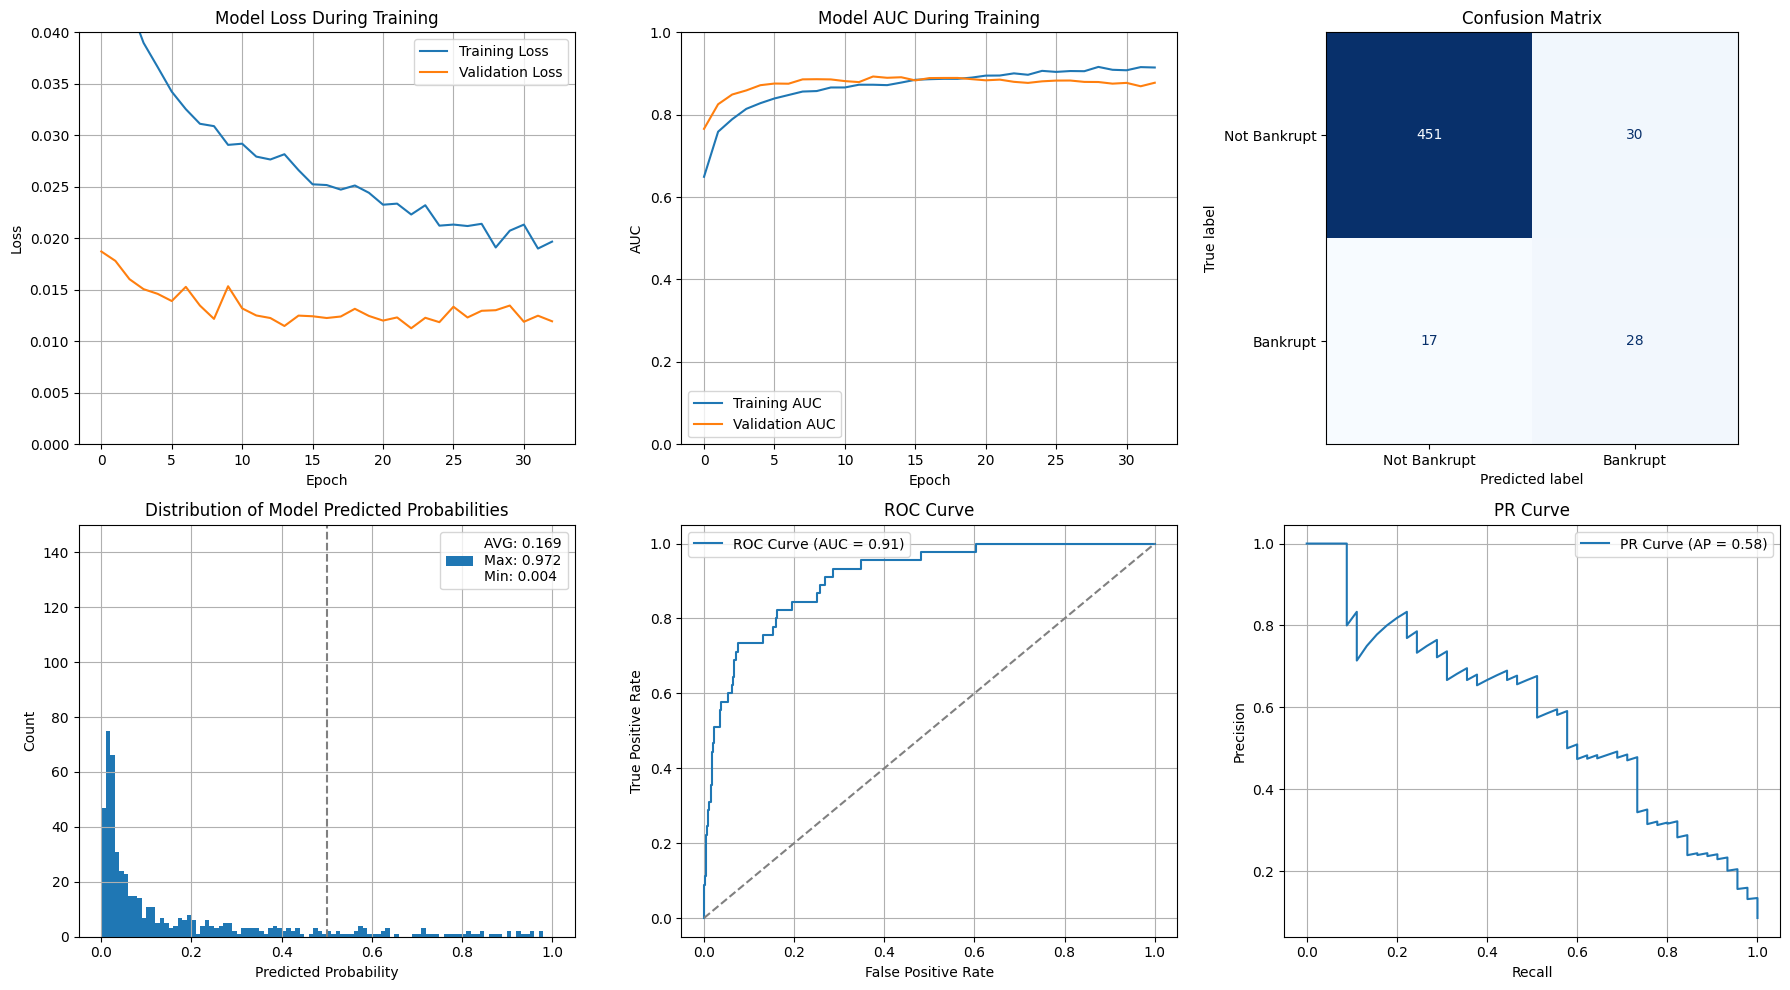

╔═══════════════════════════════╤═════════════════════╤═════════════════════════════════════════════════════════════════╗
║ Model Evaluation Table        │ Lag1:             1 │ Scaled:           1   Undersampled:     1   Oversampled:      1 ║
╟─────────────┬─────────────────┤ Lag2:             1 ├─────────────────────────────────────────────────────────────────╢
║ Fold CMs    │  TN  FP  FN  TP │ Lag3:             0 │ Under-Ratio:  0.100   Over-Ratio:   0.350   Over-Noise:   0.100 ║
╟─────────────┼─────────────────┤ Sum3:             0 ├─────────────────────┬───────────────────────────────────────────╢
║ Fold 1      │   -   -   -   - │ Avg3:             0 │ Length:       06-06 │ Gamma:            2   Alpha:        0.350 ║
║ Fold 2      │   -   -   -   - │ Flags:            1 ├─────────────────────┴─────────────────────┬─────────────────────╢
║ Fold 3      │   -   -   -   - │ Ratios:           0 │ Accuracy:     0.911   Precision:    0.483 │ Type:          LSTM ║
║ Fold 4      │   -   - 

In [12]:
def run_model(gridsearch):    

    hp = hyperparameters
    data = generate_features(dfs, hp['lag1'], hp['lag2'], hp['lag3'], hp['sum3'], hp['avg3'], hp['flags'], hp['ratios'], hp['oscore'], hp['ocomp'], hp['zscore'], hp['zcomp'])

    if gridsearch:
        search_keys = keys
        selection = gridsearch_param_selection()

        combos = get_combos(selection)

        for i, combo in enumerate(combos):
            for j, key in enumerate(search_keys):
                hp[key] = combo[j]
            
            iterations = len(combos)
            search_training_pipeline(hp, data, iterations, i+1)
            clear_output(wait=True)
    else:
        model_training_pipeline(hp, data)

def get_results():
    results = build_results_df(runs)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(results[['SCO']].head(100))

run_model(False)
get_results()